In [141]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
# from torchsummary import summary

# from pushover import notify
# from utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display
from PIL import Image as I

from imgaug import augmenters as iaa
from torchsummary import summary

In [147]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bs = 8
na = 3
printed = False

In [148]:
def randomPick(trans, n):
    tran_list = []
    global printed
    for i in range (0, n):
        tran_list.append(trans[randint(0, n-1)]) 
    
    if not printed:
        for i in range(0, n):
            print(tran_list[i].name)
        printed = True
    
    return tran_list

In [152]:
def augmentation(im):
    """
    image: 1, 3, n, n tensor
    
    output: num, 3, n, n tensor
    """
    transformations = [
        iaa.Crop(px=(0, 10), name='Crop'), # crop images from each side by 0 to 16px (randomly chosen)
        iaa.Fliplr(0.5, name='Fliplr'), # horizontally flip 50% of the images
#         iaa.Flipud(0.5, name-'Flipud'), # vertically flip 50% of the images
#         iaa.GaussianBlur(sigma=(0, 3.0), name='GaussianBlur'), # blur images with a sigma of 0 to 3.0
#         iaa.CropAndPad(pad_mode='constant', name='CropAndPad'),  # crop or pad
#         iaa.Grayscale(alpha=randint(0,255), from_colorspace='RGB', name='GrayScale', deterministic=False),
#         iaa.AverageBlur(k=[1,2,4,7,10], name='AverageBlur', deterministic=False),
#         iaa.Sharpen(alpha=randint(0,255), lightness=1, name='Sharpen', deterministic=False),
#         iaa.Emboss(alpha=randint(0,255), strength=1, name='Emboss', deterministic=False),
#         iaa.Dropout(p=0, per_channel=False, name=None, deterministic=False, random_state=None),
#         iaa.ElasticTransformation(alpha=randint(0,255),sigma=0,name='ElasticTrans', deterministic=False),
        iaa.Noop(name='Noop')
    ]

    im = im.permute(1, 2, 0).numpy()
    return torch.Tensor([t(image=im) for t in randomPick(transformations, na)]).permute(0, 3, 1, 2)

In [153]:
# dataset = datasets.ImageFolder(root='./data-nodules2d', transform = transforms.Compose([transforms.ToTensor()]))
dataset = datasets.CIFAR10('.', transform = transforms.Compose([transforms.ToTensor(), augmentation]), download = True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)


Files already downloaded and verified


Fliplr
Crop
Crop


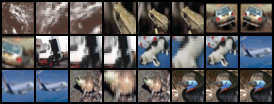

In [154]:
fixed_x, _ = next(iter(dataloader))
fixed_x = fixed_x.view(-1, 3, 32, 32)
save_image(fixed_x, 'real_image.png')
display(Image('real_image.png', width=1000, unconfined=True))
printed = False

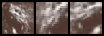

In [155]:
a = fixed_x.view(bs, na, 3, 32, 32)

save_image(a[0], 'real_image.png')
display(Image('real_image.png', width=500, unconfined=True))

### Todo: Totensor --> Numpy --> Totensor

In [156]:
x = torch.Tensor([1, 1, 1, 1]).view(1, 1, 4)

a = nn.MultiheadAttention(4, 1)
a(x, x, x)[0]

tensor([[[-0.0973,  0.0523,  0.5068,  0.2557]]], grad_fn=<AddBackward0>)

In [157]:
class Net(nn.Module):
    def __init__(self, na=4):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 512)
        
        self.conv4 = nn.Conv2d(32, 16, 3,padding = 1)
        self.conv5 = nn.Conv2d(16, 6, 3,padding = 1)
        self.conv6 = nn.Conv2d(6, 3, 3,padding = 1)
        
        self.selfattn = nn.MultiheadAttention(128, 1)
        
        self.na = na

        
    def encoder(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 32 * 4 * 4)
        x = F.relu(self.fc1(x))
        return x
    
    
    # TODO: Use Fc for pooling    
    def pooling(self, vectors):
        na = self.na
        if not na:
            return vectors
        
        vectors = vectors.view(bs, na, 128)
        vectors = vectors[:, :na-1, :]
        vectors = vectors.permute(1, 0, 2)
        vectors, _ = self.selfattn(vectors, vectors, vectors)
        return vectors.mean(dim=0)
    
    def decoder(self, vector):
        x = self.fc2(vector)
        # 1, 512 --> 1, 32, 4, 4
        x = x.reshape(-1, 32, 4, 4)
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = self.conv4(x)
        x = F.relu(x)
        
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = self.conv5(x)
        x = F.relu(x)

        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = self.conv6(x)

        x = torch.sigmoid(x)
        return x
       
        
    def forward(self, x):
        x = x.view(-1, 3, 32, 32)
        x = self.encoder(x)
        x = self.pooling(x)
        y = self.decoder(x)
        return x, y

In [158]:
# summary(net, (3, 32, 32))

In [159]:
model = Net()
model.to(device)
optimizer = optim.Adam(model.parameters())
loss = nn.MSELoss()

In [126]:
model

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=512, bias=True)
  (conv4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(16, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(6, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (selfattn): MultiheadAttention(
    (out_proj): Linear(in_features=128, out_features=128, bias=True)
  )
)

In [127]:
model.na = 4

In [128]:
for param in model.parameters():
    param.requires_grad = True

In [129]:
def train(train_loader, epochs=100):
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            
            optimizer.zero_grad()
            _, I_prime = model(data)

            I = data[:, -1, :]
            l1 = loss(I, I_prime)
            l1.backward()
            optimizer.step()

            if batch_idx % 20 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), l1.item()))

In [130]:
train(dataloader)

Fliplr
Noop
Crop
GaussianBlur
Train Epoch: 0 [0/50000 (0%)]	Loss: 0.062644
Train Epoch: 0 [16/50000 (0%)]	Loss: 0.065552
Train Epoch: 0 [32/50000 (0%)]	Loss: 0.064708
Train Epoch: 0 [48/50000 (0%)]	Loss: 0.057786
Train Epoch: 0 [64/50000 (0%)]	Loss: 0.054542
Train Epoch: 0 [80/50000 (0%)]	Loss: 0.064569
Train Epoch: 0 [96/50000 (0%)]	Loss: 0.045732
Train Epoch: 0 [112/50000 (0%)]	Loss: 0.056349
Train Epoch: 0 [128/50000 (0%)]	Loss: 0.058708
Train Epoch: 0 [144/50000 (0%)]	Loss: 0.056751
Train Epoch: 0 [160/50000 (0%)]	Loss: 0.046358
Train Epoch: 0 [176/50000 (0%)]	Loss: 0.062990
Train Epoch: 0 [192/50000 (0%)]	Loss: 0.048911
Train Epoch: 0 [208/50000 (0%)]	Loss: 0.060792
Train Epoch: 0 [224/50000 (0%)]	Loss: 0.068237
Train Epoch: 0 [240/50000 (0%)]	Loss: 0.063567
Train Epoch: 0 [256/50000 (1%)]	Loss: 0.058503
Train Epoch: 0 [272/50000 (1%)]	Loss: 0.048768
Train Epoch: 0 [288/50000 (1%)]	Loss: 0.048223
Train Epoch: 0 [304/50000 (1%)]	Loss: 0.057229
Train Epoch: 0 [320/50000 (1%)]	Loss: 

Train Epoch: 0 [2752/50000 (6%)]	Loss: 0.040823
Train Epoch: 0 [2768/50000 (6%)]	Loss: 0.043268
Train Epoch: 0 [2784/50000 (6%)]	Loss: 0.048242
Train Epoch: 0 [2800/50000 (6%)]	Loss: 0.038922
Train Epoch: 0 [2816/50000 (6%)]	Loss: 0.029084
Train Epoch: 0 [2832/50000 (6%)]	Loss: 0.027740
Train Epoch: 0 [2848/50000 (6%)]	Loss: 0.034378
Train Epoch: 0 [2864/50000 (6%)]	Loss: 0.029638
Train Epoch: 0 [2880/50000 (6%)]	Loss: 0.031344
Train Epoch: 0 [2896/50000 (6%)]	Loss: 0.030925
Train Epoch: 0 [2912/50000 (6%)]	Loss: 0.027167
Train Epoch: 0 [2928/50000 (6%)]	Loss: 0.033841
Train Epoch: 0 [2944/50000 (6%)]	Loss: 0.043379
Train Epoch: 0 [2960/50000 (6%)]	Loss: 0.033363
Train Epoch: 0 [2976/50000 (6%)]	Loss: 0.033569
Train Epoch: 0 [2992/50000 (6%)]	Loss: 0.031141
Train Epoch: 0 [3008/50000 (6%)]	Loss: 0.044137
Train Epoch: 0 [3024/50000 (6%)]	Loss: 0.028581
Train Epoch: 0 [3040/50000 (6%)]	Loss: 0.036613
Train Epoch: 0 [3056/50000 (6%)]	Loss: 0.040586
Train Epoch: 0 [3072/50000 (6%)]	Loss: 0

Train Epoch: 0 [5488/50000 (11%)]	Loss: 0.026933
Train Epoch: 0 [5504/50000 (11%)]	Loss: 0.038606
Train Epoch: 0 [5520/50000 (11%)]	Loss: 0.035668
Train Epoch: 0 [5536/50000 (11%)]	Loss: 0.029832
Train Epoch: 0 [5552/50000 (11%)]	Loss: 0.039163
Train Epoch: 0 [5568/50000 (11%)]	Loss: 0.026992
Train Epoch: 0 [5584/50000 (11%)]	Loss: 0.032680
Train Epoch: 0 [5600/50000 (11%)]	Loss: 0.039644
Train Epoch: 0 [5616/50000 (11%)]	Loss: 0.038644
Train Epoch: 0 [5632/50000 (11%)]	Loss: 0.028977
Train Epoch: 0 [5648/50000 (11%)]	Loss: 0.034493
Train Epoch: 0 [5664/50000 (11%)]	Loss: 0.025043
Train Epoch: 0 [5680/50000 (11%)]	Loss: 0.033379
Train Epoch: 0 [5696/50000 (11%)]	Loss: 0.024709
Train Epoch: 0 [5712/50000 (11%)]	Loss: 0.026641
Train Epoch: 0 [5728/50000 (11%)]	Loss: 0.028354
Train Epoch: 0 [5744/50000 (11%)]	Loss: 0.038647
Train Epoch: 0 [5760/50000 (12%)]	Loss: 0.047986
Train Epoch: 0 [5776/50000 (12%)]	Loss: 0.028752
Train Epoch: 0 [5792/50000 (12%)]	Loss: 0.028664
Train Epoch: 0 [5808

Train Epoch: 0 [8176/50000 (16%)]	Loss: 0.031667
Train Epoch: 0 [8192/50000 (16%)]	Loss: 0.033926
Train Epoch: 0 [8208/50000 (16%)]	Loss: 0.024225
Train Epoch: 0 [8224/50000 (16%)]	Loss: 0.038989
Train Epoch: 0 [8240/50000 (16%)]	Loss: 0.023271
Train Epoch: 0 [8256/50000 (17%)]	Loss: 0.025489
Train Epoch: 0 [8272/50000 (17%)]	Loss: 0.037374
Train Epoch: 0 [8288/50000 (17%)]	Loss: 0.024518
Train Epoch: 0 [8304/50000 (17%)]	Loss: 0.037998
Train Epoch: 0 [8320/50000 (17%)]	Loss: 0.028644
Train Epoch: 0 [8336/50000 (17%)]	Loss: 0.028225
Train Epoch: 0 [8352/50000 (17%)]	Loss: 0.025569
Train Epoch: 0 [8368/50000 (17%)]	Loss: 0.030670
Train Epoch: 0 [8384/50000 (17%)]	Loss: 0.022620
Train Epoch: 0 [8400/50000 (17%)]	Loss: 0.024195
Train Epoch: 0 [8416/50000 (17%)]	Loss: 0.037330
Train Epoch: 0 [8432/50000 (17%)]	Loss: 0.037151
Train Epoch: 0 [8448/50000 (17%)]	Loss: 0.034668
Train Epoch: 0 [8464/50000 (17%)]	Loss: 0.040017
Train Epoch: 0 [8480/50000 (17%)]	Loss: 0.028203
Train Epoch: 0 [8496

Train Epoch: 0 [10864/50000 (22%)]	Loss: 0.030994
Train Epoch: 0 [10880/50000 (22%)]	Loss: 0.021406
Train Epoch: 0 [10896/50000 (22%)]	Loss: 0.038274
Train Epoch: 0 [10912/50000 (22%)]	Loss: 0.021701
Train Epoch: 0 [10928/50000 (22%)]	Loss: 0.030705
Train Epoch: 0 [10944/50000 (22%)]	Loss: 0.026304
Train Epoch: 0 [10960/50000 (22%)]	Loss: 0.025601
Train Epoch: 0 [10976/50000 (22%)]	Loss: 0.030146
Train Epoch: 0 [10992/50000 (22%)]	Loss: 0.046024
Train Epoch: 0 [11008/50000 (22%)]	Loss: 0.022432
Train Epoch: 0 [11024/50000 (22%)]	Loss: 0.026064
Train Epoch: 0 [11040/50000 (22%)]	Loss: 0.032005
Train Epoch: 0 [11056/50000 (22%)]	Loss: 0.027704
Train Epoch: 0 [11072/50000 (22%)]	Loss: 0.035823
Train Epoch: 0 [11088/50000 (22%)]	Loss: 0.033253
Train Epoch: 0 [11104/50000 (22%)]	Loss: 0.032576
Train Epoch: 0 [11120/50000 (22%)]	Loss: 0.036184
Train Epoch: 0 [11136/50000 (22%)]	Loss: 0.022865
Train Epoch: 0 [11152/50000 (22%)]	Loss: 0.027998
Train Epoch: 0 [11168/50000 (22%)]	Loss: 0.032390


Train Epoch: 0 [13488/50000 (27%)]	Loss: 0.028027
Train Epoch: 0 [13504/50000 (27%)]	Loss: 0.025320
Train Epoch: 0 [13520/50000 (27%)]	Loss: 0.023126
Train Epoch: 0 [13536/50000 (27%)]	Loss: 0.030271
Train Epoch: 0 [13552/50000 (27%)]	Loss: 0.029998
Train Epoch: 0 [13568/50000 (27%)]	Loss: 0.019145
Train Epoch: 0 [13584/50000 (27%)]	Loss: 0.043795
Train Epoch: 0 [13600/50000 (27%)]	Loss: 0.028711
Train Epoch: 0 [13616/50000 (27%)]	Loss: 0.033701
Train Epoch: 0 [13632/50000 (27%)]	Loss: 0.032116
Train Epoch: 0 [13648/50000 (27%)]	Loss: 0.020790
Train Epoch: 0 [13664/50000 (27%)]	Loss: 0.020947
Train Epoch: 0 [13680/50000 (27%)]	Loss: 0.027892
Train Epoch: 0 [13696/50000 (27%)]	Loss: 0.034605
Train Epoch: 0 [13712/50000 (27%)]	Loss: 0.039594
Train Epoch: 0 [13728/50000 (27%)]	Loss: 0.016511
Train Epoch: 0 [13744/50000 (27%)]	Loss: 0.030109
Train Epoch: 0 [13760/50000 (28%)]	Loss: 0.039105
Train Epoch: 0 [13776/50000 (28%)]	Loss: 0.032001
Train Epoch: 0 [13792/50000 (28%)]	Loss: 0.037062


Train Epoch: 0 [16112/50000 (32%)]	Loss: 0.029544
Train Epoch: 0 [16128/50000 (32%)]	Loss: 0.023610
Train Epoch: 0 [16144/50000 (32%)]	Loss: 0.035065
Train Epoch: 0 [16160/50000 (32%)]	Loss: 0.022052
Train Epoch: 0 [16176/50000 (32%)]	Loss: 0.025964
Train Epoch: 0 [16192/50000 (32%)]	Loss: 0.036158
Train Epoch: 0 [16208/50000 (32%)]	Loss: 0.031995
Train Epoch: 0 [16224/50000 (32%)]	Loss: 0.038797
Train Epoch: 0 [16240/50000 (32%)]	Loss: 0.031039
Train Epoch: 0 [16256/50000 (33%)]	Loss: 0.028694
Train Epoch: 0 [16272/50000 (33%)]	Loss: 0.032312
Train Epoch: 0 [16288/50000 (33%)]	Loss: 0.023789
Train Epoch: 0 [16304/50000 (33%)]	Loss: 0.030529
Train Epoch: 0 [16320/50000 (33%)]	Loss: 0.038979
Train Epoch: 0 [16336/50000 (33%)]	Loss: 0.031182
Train Epoch: 0 [16352/50000 (33%)]	Loss: 0.033233
Train Epoch: 0 [16368/50000 (33%)]	Loss: 0.027864
Train Epoch: 0 [16384/50000 (33%)]	Loss: 0.029332
Train Epoch: 0 [16400/50000 (33%)]	Loss: 0.036251
Train Epoch: 0 [16416/50000 (33%)]	Loss: 0.030592


Train Epoch: 0 [18736/50000 (37%)]	Loss: 0.036269
Train Epoch: 0 [18752/50000 (38%)]	Loss: 0.041857
Train Epoch: 0 [18768/50000 (38%)]	Loss: 0.045107
Train Epoch: 0 [18784/50000 (38%)]	Loss: 0.025944
Train Epoch: 0 [18800/50000 (38%)]	Loss: 0.038584
Train Epoch: 0 [18816/50000 (38%)]	Loss: 0.035449
Train Epoch: 0 [18832/50000 (38%)]	Loss: 0.037155
Train Epoch: 0 [18848/50000 (38%)]	Loss: 0.019597
Train Epoch: 0 [18864/50000 (38%)]	Loss: 0.041973
Train Epoch: 0 [18880/50000 (38%)]	Loss: 0.023642
Train Epoch: 0 [18896/50000 (38%)]	Loss: 0.028054
Train Epoch: 0 [18912/50000 (38%)]	Loss: 0.028162
Train Epoch: 0 [18928/50000 (38%)]	Loss: 0.026111
Train Epoch: 0 [18944/50000 (38%)]	Loss: 0.033932
Train Epoch: 0 [18960/50000 (38%)]	Loss: 0.022527
Train Epoch: 0 [18976/50000 (38%)]	Loss: 0.027286
Train Epoch: 0 [18992/50000 (38%)]	Loss: 0.032365
Train Epoch: 0 [19008/50000 (38%)]	Loss: 0.028789
Train Epoch: 0 [19024/50000 (38%)]	Loss: 0.025522
Train Epoch: 0 [19040/50000 (38%)]	Loss: 0.037097


Train Epoch: 0 [21360/50000 (43%)]	Loss: 0.031678
Train Epoch: 0 [21376/50000 (43%)]	Loss: 0.027515
Train Epoch: 0 [21392/50000 (43%)]	Loss: 0.029120
Train Epoch: 0 [21408/50000 (43%)]	Loss: 0.031092
Train Epoch: 0 [21424/50000 (43%)]	Loss: 0.021136
Train Epoch: 0 [21440/50000 (43%)]	Loss: 0.024576
Train Epoch: 0 [21456/50000 (43%)]	Loss: 0.029874
Train Epoch: 0 [21472/50000 (43%)]	Loss: 0.024837
Train Epoch: 0 [21488/50000 (43%)]	Loss: 0.026290
Train Epoch: 0 [21504/50000 (43%)]	Loss: 0.025180
Train Epoch: 0 [21520/50000 (43%)]	Loss: 0.021307
Train Epoch: 0 [21536/50000 (43%)]	Loss: 0.022070
Train Epoch: 0 [21552/50000 (43%)]	Loss: 0.042484
Train Epoch: 0 [21568/50000 (43%)]	Loss: 0.039439
Train Epoch: 0 [21584/50000 (43%)]	Loss: 0.040047
Train Epoch: 0 [21600/50000 (43%)]	Loss: 0.026580
Train Epoch: 0 [21616/50000 (43%)]	Loss: 0.034209
Train Epoch: 0 [21632/50000 (43%)]	Loss: 0.044896
Train Epoch: 0 [21648/50000 (43%)]	Loss: 0.028242
Train Epoch: 0 [21664/50000 (43%)]	Loss: 0.026001


Train Epoch: 0 [23984/50000 (48%)]	Loss: 0.036433
Train Epoch: 0 [24000/50000 (48%)]	Loss: 0.023128
Train Epoch: 0 [24016/50000 (48%)]	Loss: 0.030813
Train Epoch: 0 [24032/50000 (48%)]	Loss: 0.023437
Train Epoch: 0 [24048/50000 (48%)]	Loss: 0.028334
Train Epoch: 0 [24064/50000 (48%)]	Loss: 0.038014
Train Epoch: 0 [24080/50000 (48%)]	Loss: 0.029006
Train Epoch: 0 [24096/50000 (48%)]	Loss: 0.028695
Train Epoch: 0 [24112/50000 (48%)]	Loss: 0.035363
Train Epoch: 0 [24128/50000 (48%)]	Loss: 0.024380
Train Epoch: 0 [24144/50000 (48%)]	Loss: 0.029082
Train Epoch: 0 [24160/50000 (48%)]	Loss: 0.023385
Train Epoch: 0 [24176/50000 (48%)]	Loss: 0.031389
Train Epoch: 0 [24192/50000 (48%)]	Loss: 0.039111
Train Epoch: 0 [24208/50000 (48%)]	Loss: 0.041341
Train Epoch: 0 [24224/50000 (48%)]	Loss: 0.030624
Train Epoch: 0 [24240/50000 (48%)]	Loss: 0.036015
Train Epoch: 0 [24256/50000 (49%)]	Loss: 0.055682
Train Epoch: 0 [24272/50000 (49%)]	Loss: 0.030813
Train Epoch: 0 [24288/50000 (49%)]	Loss: 0.031275


Train Epoch: 0 [26624/50000 (53%)]	Loss: 0.030446
Train Epoch: 0 [26640/50000 (53%)]	Loss: 0.027947
Train Epoch: 0 [26656/50000 (53%)]	Loss: 0.034150
Train Epoch: 0 [26672/50000 (53%)]	Loss: 0.033661
Train Epoch: 0 [26688/50000 (53%)]	Loss: 0.024193
Train Epoch: 0 [26704/50000 (53%)]	Loss: 0.029379
Train Epoch: 0 [26720/50000 (53%)]	Loss: 0.034012
Train Epoch: 0 [26736/50000 (53%)]	Loss: 0.026207
Train Epoch: 0 [26752/50000 (54%)]	Loss: 0.034999
Train Epoch: 0 [26768/50000 (54%)]	Loss: 0.027075
Train Epoch: 0 [26784/50000 (54%)]	Loss: 0.045163
Train Epoch: 0 [26800/50000 (54%)]	Loss: 0.034083
Train Epoch: 0 [26816/50000 (54%)]	Loss: 0.025794
Train Epoch: 0 [26832/50000 (54%)]	Loss: 0.027351
Train Epoch: 0 [26848/50000 (54%)]	Loss: 0.039542
Train Epoch: 0 [26864/50000 (54%)]	Loss: 0.022569
Train Epoch: 0 [26880/50000 (54%)]	Loss: 0.022109
Train Epoch: 0 [26896/50000 (54%)]	Loss: 0.034198
Train Epoch: 0 [26912/50000 (54%)]	Loss: 0.026981
Train Epoch: 0 [26928/50000 (54%)]	Loss: 0.029266


Train Epoch: 0 [29264/50000 (59%)]	Loss: 0.026605
Train Epoch: 0 [29280/50000 (59%)]	Loss: 0.018230
Train Epoch: 0 [29296/50000 (59%)]	Loss: 0.024056
Train Epoch: 0 [29312/50000 (59%)]	Loss: 0.026846
Train Epoch: 0 [29328/50000 (59%)]	Loss: 0.029002
Train Epoch: 0 [29344/50000 (59%)]	Loss: 0.032822
Train Epoch: 0 [29360/50000 (59%)]	Loss: 0.026779
Train Epoch: 0 [29376/50000 (59%)]	Loss: 0.025054
Train Epoch: 0 [29392/50000 (59%)]	Loss: 0.025443
Train Epoch: 0 [29408/50000 (59%)]	Loss: 0.029312
Train Epoch: 0 [29424/50000 (59%)]	Loss: 0.017442
Train Epoch: 0 [29440/50000 (59%)]	Loss: 0.030639
Train Epoch: 0 [29456/50000 (59%)]	Loss: 0.036005
Train Epoch: 0 [29472/50000 (59%)]	Loss: 0.036775
Train Epoch: 0 [29488/50000 (59%)]	Loss: 0.025284
Train Epoch: 0 [29504/50000 (59%)]	Loss: 0.037042
Train Epoch: 0 [29520/50000 (59%)]	Loss: 0.031135
Train Epoch: 0 [29536/50000 (59%)]	Loss: 0.023274
Train Epoch: 0 [29552/50000 (59%)]	Loss: 0.027713
Train Epoch: 0 [29568/50000 (59%)]	Loss: 0.042262


Train Epoch: 0 [31888/50000 (64%)]	Loss: 0.037806
Train Epoch: 0 [31904/50000 (64%)]	Loss: 0.022899
Train Epoch: 0 [31920/50000 (64%)]	Loss: 0.027881
Train Epoch: 0 [31936/50000 (64%)]	Loss: 0.022394
Train Epoch: 0 [31952/50000 (64%)]	Loss: 0.024265
Train Epoch: 0 [31968/50000 (64%)]	Loss: 0.028150
Train Epoch: 0 [31984/50000 (64%)]	Loss: 0.024145
Train Epoch: 0 [32000/50000 (64%)]	Loss: 0.030456
Train Epoch: 0 [32016/50000 (64%)]	Loss: 0.029898
Train Epoch: 0 [32032/50000 (64%)]	Loss: 0.020693
Train Epoch: 0 [32048/50000 (64%)]	Loss: 0.021979
Train Epoch: 0 [32064/50000 (64%)]	Loss: 0.036283
Train Epoch: 0 [32080/50000 (64%)]	Loss: 0.020275
Train Epoch: 0 [32096/50000 (64%)]	Loss: 0.022550
Train Epoch: 0 [32112/50000 (64%)]	Loss: 0.036853
Train Epoch: 0 [32128/50000 (64%)]	Loss: 0.028047
Train Epoch: 0 [32144/50000 (64%)]	Loss: 0.029764
Train Epoch: 0 [32160/50000 (64%)]	Loss: 0.031259
Train Epoch: 0 [32176/50000 (64%)]	Loss: 0.032038
Train Epoch: 0 [32192/50000 (64%)]	Loss: 0.024697


Train Epoch: 0 [34528/50000 (69%)]	Loss: 0.025254
Train Epoch: 0 [34544/50000 (69%)]	Loss: 0.027076
Train Epoch: 0 [34560/50000 (69%)]	Loss: 0.039165
Train Epoch: 0 [34576/50000 (69%)]	Loss: 0.032414
Train Epoch: 0 [34592/50000 (69%)]	Loss: 0.019408
Train Epoch: 0 [34608/50000 (69%)]	Loss: 0.019737
Train Epoch: 0 [34624/50000 (69%)]	Loss: 0.028095
Train Epoch: 0 [34640/50000 (69%)]	Loss: 0.022636
Train Epoch: 0 [34656/50000 (69%)]	Loss: 0.021336
Train Epoch: 0 [34672/50000 (69%)]	Loss: 0.044302
Train Epoch: 0 [34688/50000 (69%)]	Loss: 0.029039
Train Epoch: 0 [34704/50000 (69%)]	Loss: 0.024438
Train Epoch: 0 [34720/50000 (69%)]	Loss: 0.024392
Train Epoch: 0 [34736/50000 (69%)]	Loss: 0.058858
Train Epoch: 0 [34752/50000 (70%)]	Loss: 0.037858
Train Epoch: 0 [34768/50000 (70%)]	Loss: 0.039806
Train Epoch: 0 [34784/50000 (70%)]	Loss: 0.043052
Train Epoch: 0 [34800/50000 (70%)]	Loss: 0.053473
Train Epoch: 0 [34816/50000 (70%)]	Loss: 0.024801
Train Epoch: 0 [34832/50000 (70%)]	Loss: 0.027188


Train Epoch: 0 [37152/50000 (74%)]	Loss: 0.036064
Train Epoch: 0 [37168/50000 (74%)]	Loss: 0.021042
Train Epoch: 0 [37184/50000 (74%)]	Loss: 0.032094
Train Epoch: 0 [37200/50000 (74%)]	Loss: 0.031369
Train Epoch: 0 [37216/50000 (74%)]	Loss: 0.027955
Train Epoch: 0 [37232/50000 (74%)]	Loss: 0.039524
Train Epoch: 0 [37248/50000 (74%)]	Loss: 0.038093
Train Epoch: 0 [37264/50000 (75%)]	Loss: 0.032703
Train Epoch: 0 [37280/50000 (75%)]	Loss: 0.022241
Train Epoch: 0 [37296/50000 (75%)]	Loss: 0.022757
Train Epoch: 0 [37312/50000 (75%)]	Loss: 0.029985
Train Epoch: 0 [37328/50000 (75%)]	Loss: 0.032709
Train Epoch: 0 [37344/50000 (75%)]	Loss: 0.031462
Train Epoch: 0 [37360/50000 (75%)]	Loss: 0.027580
Train Epoch: 0 [37376/50000 (75%)]	Loss: 0.026935
Train Epoch: 0 [37392/50000 (75%)]	Loss: 0.025821
Train Epoch: 0 [37408/50000 (75%)]	Loss: 0.022169
Train Epoch: 0 [37424/50000 (75%)]	Loss: 0.022537
Train Epoch: 0 [37440/50000 (75%)]	Loss: 0.026374
Train Epoch: 0 [37456/50000 (75%)]	Loss: 0.019238


Train Epoch: 0 [39776/50000 (80%)]	Loss: 0.021927
Train Epoch: 0 [39792/50000 (80%)]	Loss: 0.028154
Train Epoch: 0 [39808/50000 (80%)]	Loss: 0.020450
Train Epoch: 0 [39824/50000 (80%)]	Loss: 0.028568
Train Epoch: 0 [39840/50000 (80%)]	Loss: 0.037237
Train Epoch: 0 [39856/50000 (80%)]	Loss: 0.033973
Train Epoch: 0 [39872/50000 (80%)]	Loss: 0.016284
Train Epoch: 0 [39888/50000 (80%)]	Loss: 0.039381
Train Epoch: 0 [39904/50000 (80%)]	Loss: 0.020232
Train Epoch: 0 [39920/50000 (80%)]	Loss: 0.029754
Train Epoch: 0 [39936/50000 (80%)]	Loss: 0.030601
Train Epoch: 0 [39952/50000 (80%)]	Loss: 0.033402
Train Epoch: 0 [39968/50000 (80%)]	Loss: 0.031741
Train Epoch: 0 [39984/50000 (80%)]	Loss: 0.024174
Train Epoch: 0 [40000/50000 (80%)]	Loss: 0.029866
Train Epoch: 0 [40016/50000 (80%)]	Loss: 0.036467
Train Epoch: 0 [40032/50000 (80%)]	Loss: 0.026896
Train Epoch: 0 [40048/50000 (80%)]	Loss: 0.034972
Train Epoch: 0 [40064/50000 (80%)]	Loss: 0.026578
Train Epoch: 0 [40080/50000 (80%)]	Loss: 0.051543


Train Epoch: 0 [42400/50000 (85%)]	Loss: 0.022315
Train Epoch: 0 [42416/50000 (85%)]	Loss: 0.032360
Train Epoch: 0 [42432/50000 (85%)]	Loss: 0.029793
Train Epoch: 0 [42448/50000 (85%)]	Loss: 0.024417
Train Epoch: 0 [42464/50000 (85%)]	Loss: 0.034469
Train Epoch: 0 [42480/50000 (85%)]	Loss: 0.022626
Train Epoch: 0 [42496/50000 (85%)]	Loss: 0.018571
Train Epoch: 0 [42512/50000 (85%)]	Loss: 0.029736
Train Epoch: 0 [42528/50000 (85%)]	Loss: 0.030709
Train Epoch: 0 [42544/50000 (85%)]	Loss: 0.027070
Train Epoch: 0 [42560/50000 (85%)]	Loss: 0.030357
Train Epoch: 0 [42576/50000 (85%)]	Loss: 0.023957
Train Epoch: 0 [42592/50000 (85%)]	Loss: 0.039052
Train Epoch: 0 [42608/50000 (85%)]	Loss: 0.033084
Train Epoch: 0 [42624/50000 (85%)]	Loss: 0.024575
Train Epoch: 0 [42640/50000 (85%)]	Loss: 0.027214
Train Epoch: 0 [42656/50000 (85%)]	Loss: 0.015337
Train Epoch: 0 [42672/50000 (85%)]	Loss: 0.018818
Train Epoch: 0 [42688/50000 (85%)]	Loss: 0.039877
Train Epoch: 0 [42704/50000 (85%)]	Loss: 0.035087


Train Epoch: 0 [45024/50000 (90%)]	Loss: 0.039321
Train Epoch: 0 [45040/50000 (90%)]	Loss: 0.022191
Train Epoch: 0 [45056/50000 (90%)]	Loss: 0.022883
Train Epoch: 0 [45072/50000 (90%)]	Loss: 0.028120
Train Epoch: 0 [45088/50000 (90%)]	Loss: 0.023548
Train Epoch: 0 [45104/50000 (90%)]	Loss: 0.027376
Train Epoch: 0 [45120/50000 (90%)]	Loss: 0.027697
Train Epoch: 0 [45136/50000 (90%)]	Loss: 0.023134
Train Epoch: 0 [45152/50000 (90%)]	Loss: 0.019375
Train Epoch: 0 [45168/50000 (90%)]	Loss: 0.030651
Train Epoch: 0 [45184/50000 (90%)]	Loss: 0.017826
Train Epoch: 0 [45200/50000 (90%)]	Loss: 0.031921
Train Epoch: 0 [45216/50000 (90%)]	Loss: 0.020649
Train Epoch: 0 [45232/50000 (90%)]	Loss: 0.026360
Train Epoch: 0 [45248/50000 (90%)]	Loss: 0.027103
Train Epoch: 0 [45264/50000 (91%)]	Loss: 0.028461
Train Epoch: 0 [45280/50000 (91%)]	Loss: 0.024535
Train Epoch: 0 [45296/50000 (91%)]	Loss: 0.024158
Train Epoch: 0 [45312/50000 (91%)]	Loss: 0.038607
Train Epoch: 0 [45328/50000 (91%)]	Loss: 0.035479


Train Epoch: 0 [47648/50000 (95%)]	Loss: 0.021577
Train Epoch: 0 [47664/50000 (95%)]	Loss: 0.029984
Train Epoch: 0 [47680/50000 (95%)]	Loss: 0.024256
Train Epoch: 0 [47696/50000 (95%)]	Loss: 0.026219
Train Epoch: 0 [47712/50000 (95%)]	Loss: 0.021488
Train Epoch: 0 [47728/50000 (95%)]	Loss: 0.029611
Train Epoch: 0 [47744/50000 (95%)]	Loss: 0.019459
Train Epoch: 0 [47760/50000 (96%)]	Loss: 0.022561
Train Epoch: 0 [47776/50000 (96%)]	Loss: 0.018175
Train Epoch: 0 [47792/50000 (96%)]	Loss: 0.025440
Train Epoch: 0 [47808/50000 (96%)]	Loss: 0.032305
Train Epoch: 0 [47824/50000 (96%)]	Loss: 0.026141
Train Epoch: 0 [47840/50000 (96%)]	Loss: 0.018894
Train Epoch: 0 [47856/50000 (96%)]	Loss: 0.035334
Train Epoch: 0 [47872/50000 (96%)]	Loss: 0.031294
Train Epoch: 0 [47888/50000 (96%)]	Loss: 0.028307
Train Epoch: 0 [47904/50000 (96%)]	Loss: 0.030058
Train Epoch: 0 [47920/50000 (96%)]	Loss: 0.032901
Train Epoch: 0 [47936/50000 (96%)]	Loss: 0.021397
Train Epoch: 0 [47952/50000 (96%)]	Loss: 0.017035


Train Epoch: 1 [304/50000 (1%)]	Loss: 0.016994
Train Epoch: 1 [320/50000 (1%)]	Loss: 0.023384
Train Epoch: 1 [336/50000 (1%)]	Loss: 0.025781
Train Epoch: 1 [352/50000 (1%)]	Loss: 0.023592
Train Epoch: 1 [368/50000 (1%)]	Loss: 0.039894
Train Epoch: 1 [384/50000 (1%)]	Loss: 0.025660
Train Epoch: 1 [400/50000 (1%)]	Loss: 0.019348
Train Epoch: 1 [416/50000 (1%)]	Loss: 0.035776
Train Epoch: 1 [432/50000 (1%)]	Loss: 0.021900
Train Epoch: 1 [448/50000 (1%)]	Loss: 0.014924
Train Epoch: 1 [464/50000 (1%)]	Loss: 0.041287
Train Epoch: 1 [480/50000 (1%)]	Loss: 0.027196
Train Epoch: 1 [496/50000 (1%)]	Loss: 0.028090
Train Epoch: 1 [512/50000 (1%)]	Loss: 0.027345
Train Epoch: 1 [528/50000 (1%)]	Loss: 0.038974
Train Epoch: 1 [544/50000 (1%)]	Loss: 0.024162
Train Epoch: 1 [560/50000 (1%)]	Loss: 0.032872
Train Epoch: 1 [576/50000 (1%)]	Loss: 0.021706
Train Epoch: 1 [592/50000 (1%)]	Loss: 0.031492
Train Epoch: 1 [608/50000 (1%)]	Loss: 0.027006
Train Epoch: 1 [624/50000 (1%)]	Loss: 0.036874
Train Epoch: 

Train Epoch: 1 [3056/50000 (6%)]	Loss: 0.026663
Train Epoch: 1 [3072/50000 (6%)]	Loss: 0.027835
Train Epoch: 1 [3088/50000 (6%)]	Loss: 0.025092
Train Epoch: 1 [3104/50000 (6%)]	Loss: 0.023448
Train Epoch: 1 [3120/50000 (6%)]	Loss: 0.027914
Train Epoch: 1 [3136/50000 (6%)]	Loss: 0.016678
Train Epoch: 1 [3152/50000 (6%)]	Loss: 0.019078
Train Epoch: 1 [3168/50000 (6%)]	Loss: 0.031035
Train Epoch: 1 [3184/50000 (6%)]	Loss: 0.018361
Train Epoch: 1 [3200/50000 (6%)]	Loss: 0.032777
Train Epoch: 1 [3216/50000 (6%)]	Loss: 0.025673
Train Epoch: 1 [3232/50000 (6%)]	Loss: 0.023105
Train Epoch: 1 [3248/50000 (6%)]	Loss: 0.014621
Train Epoch: 1 [3264/50000 (7%)]	Loss: 0.027085
Train Epoch: 1 [3280/50000 (7%)]	Loss: 0.021703
Train Epoch: 1 [3296/50000 (7%)]	Loss: 0.025586
Train Epoch: 1 [3312/50000 (7%)]	Loss: 0.029967
Train Epoch: 1 [3328/50000 (7%)]	Loss: 0.024590
Train Epoch: 1 [3344/50000 (7%)]	Loss: 0.036092
Train Epoch: 1 [3360/50000 (7%)]	Loss: 0.021259
Train Epoch: 1 [3376/50000 (7%)]	Loss: 0

Train Epoch: 1 [5776/50000 (12%)]	Loss: 0.021319
Train Epoch: 1 [5792/50000 (12%)]	Loss: 0.022209
Train Epoch: 1 [5808/50000 (12%)]	Loss: 0.029292
Train Epoch: 1 [5824/50000 (12%)]	Loss: 0.021651
Train Epoch: 1 [5840/50000 (12%)]	Loss: 0.021061
Train Epoch: 1 [5856/50000 (12%)]	Loss: 0.024912
Train Epoch: 1 [5872/50000 (12%)]	Loss: 0.019275
Train Epoch: 1 [5888/50000 (12%)]	Loss: 0.021144
Train Epoch: 1 [5904/50000 (12%)]	Loss: 0.023067
Train Epoch: 1 [5920/50000 (12%)]	Loss: 0.018524
Train Epoch: 1 [5936/50000 (12%)]	Loss: 0.030083
Train Epoch: 1 [5952/50000 (12%)]	Loss: 0.040462
Train Epoch: 1 [5968/50000 (12%)]	Loss: 0.023737
Train Epoch: 1 [5984/50000 (12%)]	Loss: 0.027278
Train Epoch: 1 [6000/50000 (12%)]	Loss: 0.024615
Train Epoch: 1 [6016/50000 (12%)]	Loss: 0.025223
Train Epoch: 1 [6032/50000 (12%)]	Loss: 0.019340
Train Epoch: 1 [6048/50000 (12%)]	Loss: 0.016958
Train Epoch: 1 [6064/50000 (12%)]	Loss: 0.023722
Train Epoch: 1 [6080/50000 (12%)]	Loss: 0.026653
Train Epoch: 1 [6096

KeyboardInterrupt: 

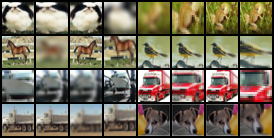

In [131]:
fixed_x, _ = next(iter(dataloader))
fixed_x = fixed_x.view(-1, 3, 32, 32)
save_image(fixed_x, 'real_image.png')
display(Image('real_image.png', width=1000, unconfined=True))

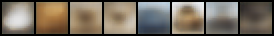

In [132]:
_, im = model(fixed_x)
save_image(im, 'real_image.png')
display(Image('real_image.png', width=1000, unconfined=True))

In [133]:
for param in model.parameters():
    param.requires_grad = False

### Evaluation starts here

In [134]:
class Evaluate(nn.Module):
    def __init__(self):
        super(Evaluate, self).__init__()
        self.fc1 = nn.Linear(128, 10)
    
    def forward(self,vector):
        x = self.fc1(vector)
        return x

In [135]:
net = Evaluate()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

net

Evaluate(
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)

### Dataloader

In [136]:
trainset = torchvision.datasets.CIFAR10(root='.',transform = transforms.Compose([transforms.ToTensor()]),
                                        train=True,download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

Files already downloaded and verified


In [137]:
model.na = False

In [138]:
fixed_x, _ = next(iter(trainloader))

In [139]:
def evaluation(trainloader):
    epoch = 1
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data) in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()

        I_pool, _ = model(inputs)
        outputs = net(I_pool)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if batch_idx % 10000:
            print('Step: [%5d] loss: %.3f' %(batch_idx + 1, loss.item()))
    
    print('Accuracy of the network: %d %%' % (100 * correct / total))

print('Finished Training')

Finished Training


In [140]:
evaluation(trainloader)

Step: [    2] loss: 2.289
Step: [    3] loss: 2.326
Step: [    4] loss: 2.288
Step: [    5] loss: 2.277
Step: [    6] loss: 2.287
Step: [    7] loss: 2.292
Step: [    8] loss: 2.268
Step: [    9] loss: 2.264
Step: [   10] loss: 2.334
Step: [   11] loss: 2.289
Step: [   12] loss: 2.302
Step: [   13] loss: 2.284
Step: [   14] loss: 2.272
Step: [   15] loss: 2.268
Step: [   16] loss: 2.295
Step: [   17] loss: 2.305
Step: [   18] loss: 2.276
Step: [   19] loss: 2.292
Step: [   20] loss: 2.268
Step: [   21] loss: 2.264
Step: [   22] loss: 2.285
Step: [   23] loss: 2.275
Step: [   24] loss: 2.313
Step: [   25] loss: 2.278
Step: [   26] loss: 2.268
Step: [   27] loss: 2.253
Step: [   28] loss: 2.260
Step: [   29] loss: 2.302
Step: [   30] loss: 2.268
Step: [   31] loss: 2.267
Step: [   32] loss: 2.261
Step: [   33] loss: 2.260
Step: [   34] loss: 2.247
Step: [   35] loss: 2.245
Step: [   36] loss: 2.302
Step: [   37] loss: 2.257
Step: [   38] loss: 2.242
Step: [   39] loss: 2.227
Step: [   40

Step: [  320] loss: 2.112
Step: [  321] loss: 2.236
Step: [  322] loss: 2.094
Step: [  323] loss: 2.225
Step: [  324] loss: 2.152
Step: [  325] loss: 2.158
Step: [  326] loss: 2.156
Step: [  327] loss: 2.210
Step: [  328] loss: 2.112
Step: [  329] loss: 2.274
Step: [  330] loss: 2.194
Step: [  331] loss: 2.087
Step: [  332] loss: 2.101
Step: [  333] loss: 2.092
Step: [  334] loss: 2.117
Step: [  335] loss: 2.148
Step: [  336] loss: 2.133
Step: [  337] loss: 2.129
Step: [  338] loss: 2.093
Step: [  339] loss: 2.027
Step: [  340] loss: 2.169
Step: [  341] loss: 2.104
Step: [  342] loss: 2.169
Step: [  343] loss: 2.140
Step: [  344] loss: 2.263
Step: [  345] loss: 2.169
Step: [  346] loss: 2.152
Step: [  347] loss: 2.148
Step: [  348] loss: 2.202
Step: [  349] loss: 2.128
Step: [  350] loss: 2.108
Step: [  351] loss: 2.100
Step: [  352] loss: 2.052
Step: [  353] loss: 2.138
Step: [  354] loss: 2.091
Step: [  355] loss: 2.131
Step: [  356] loss: 2.126
Step: [  357] loss: 2.125
Step: [  358

Step: [  653] loss: 2.138
Step: [  654] loss: 2.134
Step: [  655] loss: 2.016
Step: [  656] loss: 2.040
Step: [  657] loss: 2.140
Step: [  658] loss: 2.143
Step: [  659] loss: 2.163
Step: [  660] loss: 2.115
Step: [  661] loss: 2.031
Step: [  662] loss: 2.135
Step: [  663] loss: 1.992
Step: [  664] loss: 2.099
Step: [  665] loss: 2.128
Step: [  666] loss: 2.096
Step: [  667] loss: 2.032
Step: [  668] loss: 2.071
Step: [  669] loss: 2.122
Step: [  670] loss: 1.987
Step: [  671] loss: 2.111
Step: [  672] loss: 2.120
Step: [  673] loss: 2.022
Step: [  674] loss: 2.069
Step: [  675] loss: 2.061
Step: [  676] loss: 2.111
Step: [  677] loss: 2.080
Step: [  678] loss: 2.023
Step: [  679] loss: 2.020
Step: [  680] loss: 2.163
Step: [  681] loss: 2.048
Step: [  682] loss: 1.962
Step: [  683] loss: 2.175
Step: [  684] loss: 2.024
Step: [  685] loss: 1.863
Step: [  686] loss: 2.146
Step: [  687] loss: 2.025
Step: [  688] loss: 2.150
Step: [  689] loss: 1.961
Step: [  690] loss: 2.083
Step: [  691

Step: [  982] loss: 2.191
Step: [  983] loss: 2.141
Step: [  984] loss: 2.044
Step: [  985] loss: 2.226
Step: [  986] loss: 2.028
Step: [  987] loss: 2.050
Step: [  988] loss: 1.970
Step: [  989] loss: 1.999
Step: [  990] loss: 1.970
Step: [  991] loss: 2.163
Step: [  992] loss: 1.928
Step: [  993] loss: 1.987
Step: [  994] loss: 2.018
Step: [  995] loss: 2.079
Step: [  996] loss: 1.937
Step: [  997] loss: 1.974
Step: [  998] loss: 2.041
Step: [  999] loss: 2.047
Step: [ 1000] loss: 2.029
Step: [ 1001] loss: 1.964
Step: [ 1002] loss: 2.102
Step: [ 1003] loss: 1.904
Step: [ 1004] loss: 1.953
Step: [ 1005] loss: 1.953
Step: [ 1006] loss: 1.987
Step: [ 1007] loss: 1.993
Step: [ 1008] loss: 2.143
Step: [ 1009] loss: 1.965
Step: [ 1010] loss: 2.056
Step: [ 1011] loss: 1.898
Step: [ 1012] loss: 2.073
Step: [ 1013] loss: 1.992
Step: [ 1014] loss: 1.908
Step: [ 1015] loss: 1.959
Step: [ 1016] loss: 2.014
Step: [ 1017] loss: 2.004
Step: [ 1018] loss: 2.034
Step: [ 1019] loss: 1.716
Step: [ 1020

Step: [ 1304] loss: 1.974
Step: [ 1305] loss: 1.870
Step: [ 1306] loss: 1.959
Step: [ 1307] loss: 2.003
Step: [ 1308] loss: 1.905
Step: [ 1309] loss: 2.014
Step: [ 1310] loss: 1.992
Step: [ 1311] loss: 1.891
Step: [ 1312] loss: 2.031
Step: [ 1313] loss: 1.947
Step: [ 1314] loss: 2.011
Step: [ 1315] loss: 2.112
Step: [ 1316] loss: 2.145
Step: [ 1317] loss: 1.990
Step: [ 1318] loss: 2.116
Step: [ 1319] loss: 2.122
Step: [ 1320] loss: 2.062
Step: [ 1321] loss: 1.943
Step: [ 1322] loss: 2.002
Step: [ 1323] loss: 1.974
Step: [ 1324] loss: 1.997
Step: [ 1325] loss: 2.054
Step: [ 1326] loss: 1.907
Step: [ 1327] loss: 2.170
Step: [ 1328] loss: 1.887
Step: [ 1329] loss: 1.856
Step: [ 1330] loss: 1.973
Step: [ 1331] loss: 1.919
Step: [ 1332] loss: 2.018
Step: [ 1333] loss: 1.945
Step: [ 1334] loss: 2.098
Step: [ 1335] loss: 1.904
Step: [ 1336] loss: 2.107
Step: [ 1337] loss: 1.888
Step: [ 1338] loss: 2.054
Step: [ 1339] loss: 2.146
Step: [ 1340] loss: 2.015
Step: [ 1341] loss: 2.090
Step: [ 1342